In [42]:
# Import packages
import os
import re
import PyPDF2
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.probability import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenne\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenne\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lenne\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
# Download the pdfs from our S3 bucket
#import requests
#
#url = 'https://mda-georgia-bucket.s3.eu-central-1.amazonaws.com/Articles/article10.pdf'
#
#response = requests.get(url)
#with open('local_file.pdf', 'wb') as f:
#    f.write(response.content)
#print('PDF file downloaded successfully.')

In [60]:
# Define a function to extract text from PDF file
def extract_text_from_pdf(file_path):
    if not os.path.exists(file_path):
        print("File not found:", file_path)
        return ""

    try:
        with open(file_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            num_pages = len(pdf_reader.pages)
            text = ""

            for page_number in range(num_pages):
                page = pdf_reader.pages[page_number]
                text += page.extract_text()

        return text
    except Exception as e:
        print("Error occurred while extracting text:", str(e))
        return ""


# Define a function to preprocess the text
def preprocess_text(text):
    # Remove noise, white spaces, and punctuation using regular expressions
    text = re.sub(r'\s+', ' ', text)  # Remove extra white spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d', '', text)  # Remove numbers

    # Remove linebreaks
    text = text.replace('\n', ' ')

    # Tokenization
    tokens = word_tokenize(text)

    # Convert to lowercase
    tokens = [token.lower() for token in tokens]

    # Stop word removal
    stop_words = set(stopwords.words('english'))
    # Add "et", "al", "accessed", months, ... to stopwords (to remove "accessed {monthname}")
    stop_words.update(["et", "al", "doi", "vol", "accessed", "january", "february", "march", "april", "may", "june", "august", "september", "october", 
                        "november", "december", "british", "bulletin", "downloaded", "guest", "bcn", "patient", "cluster", "model", "results", "data", "analysis"])  
    # stop_words.update(["noise"]) # not sure whether or not to put noise as a stopword
    tokens = [token for token in tokens if token not in stop_words]

    # Remove tokens containing numbers or the word "http", remove stopwords, remove tokens of length <=2
    tokens = [token for token in tokens if not any(char.isdigit() for char in token)
              and "http" not in token and token.lower() not in stop_words
              and not (len(token) <= 2)]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    stop_words.update(["study"]) # this can only be added here to the stop words or it will still appear in the results (because can be noun, verb, ...)
    tokens = [token for token in tokens if token not in stop_words]

    return tokens


# Define a function to perform part of speech tagging
def pos_tagging(tokens):
    tagged_tokens = pos_tag(tokens)
    return tagged_tokens
    

# Define a function to extract bag of words and 2-grams
def extract_bag_of_words(tokens):
    # Bag of Words
    word_freq = FreqDist(tokens)
    most_common_words = word_freq.most_common()

    # 2-grams
    bigram_measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokens)
    n_gram_scores = finder.score_ngrams(bigram_measures.raw_freq)
    most_common_2grams = sorted(n_gram_scores, key=lambda x: x[1], reverse=True)

    return most_common_words, most_common_2grams


# Define a function for text summarization
def text_summarization(text):
    sentences = sent_tokenize(text)

    # Extract the most frequent words
    tokens = word_tokenize(text)
    word_freq = FreqDist(tokens)
    most_common_words = [word for word, _ in word_freq.most_common(10)]

    # Select short sentences that contain the most frequent words
    selected_sentences = []
    for sentence in sentences:
        sentence_tokens = word_tokenize(sentence)
        common_words_count = sum(1 for token in sentence_tokens if token in most_common_words)
        if common_words_count >= 3:
            selected_sentences.append(sentence)

    return selected_sentences


# Define a function for sentiment analysis
def sentiment_analysis(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(text)
    return sentiment_scores


# Define a function for topic modelling (Latent Dirichlet Allocation)
def latent_dirichlet_allocation(tokens, num_topics=3):
    if len(tokens) == 0:
        print("No tokens available for topic modeling.")
        return []

    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform([' '.join(tokens)])

    if len(vectorizer.get_feature_names()) == 0:
        print("Empty vocabulary. The documents may only contain stop words.")
        return []

    feature_names = vectorizer.get_feature_names()

    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(X)

    topic_keywords = []
    for topic_idx, topic in enumerate(lda.components_):
        top_indices = topic.argsort()[:-11:-1]
        topic_keywords.append([feature_names[i] for i in top_indices])

    return topic_keywords


# Define a function to generate a word cloud
def generate_word_cloud(tokens, max_words=15):
    text = ' '.join(tokens)
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=max_words).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Processed all files
Most common words: [('noise', 1145), ('health', 428), ('pollution', 300), ('exposure', 285), ('sound', 261), ('level', 246), ('environmental', 230), ('effect', 198), ('sleep', 159), ('acoustic', 159), ('air', 150), ('city', 144), ('also', 133), ('pressure', 129), ('node', 117), ('spatial', 109), ('research', 105), ('environ', 98), ('value', 98), ('traffic', 97), ('road', 95), ('urban', 92), ('public', 90), ('area', 90), ('environment', 89), ('source', 84), ('using', 80), ('risk', 77), ('population', 76), ('people', 76), ('high', 76), ('higher', 73), ('number', 73), ('impact', 72), ('variable', 72), ('annoyance', 72), ('one', 72), ('crossref', 72), ('year', 71), ('disease', 67), ('child', 67), ('due', 63), ('dba', 63), ('time', 63), ('disturbance', 62), ('inequality', 61), ('quality', 61), ('exposed', 60), ('period', 60), ('based', 59), ('indicator', 59), ('used', 59), ('per', 58), ('related', 58), ('found', 57), ('mean', 56), ('rate', 56), ('map', 54), ('socioeconom

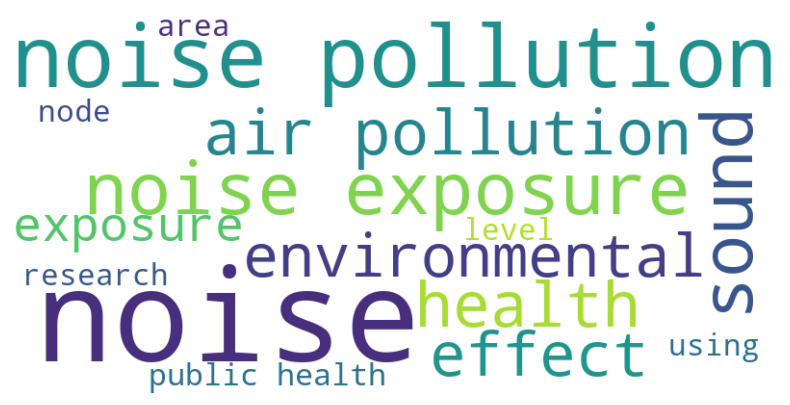

Selected sentences: ['Contents lists available at ScienceDirect\nSSM - Population Health\njournal homepage: www.elsevier.com/locate/ssmph\nArticle\nUnequal residential exposure to air pollution and noise: A geospatial\nenvironmental justice analysis for Ghent, Belgium\nThomas Verbeeka,b,⁎\naDepartment of Sociology, University of Warwick, Coventry, United Kingdom\nbCentre for Mobility and Spatial Planning, Ghent University, Ghent, Belgium\nARTICLE INFO\nKeywords:\nAir pollutionNoiseEnvironmental inequality\nEnvironmental justice\nSpatial autocorrelationSpatial regressionABSTRACT\nFollowing the growing empirical evidence on the health eﬀ ects of air pollution and noise, the fair distribution of\nthese impacts receives increasing attention.', 'The existing environmental inequality studies often focus on a single\nenvironmental impact, apply a limited range of covariates or do not correct for spatial autocorrelation.', 'This\narticle presents a geospatial data analysis on Ghent (Belgium), 

In [61]:
# Get the folder_path where the file is in (= current working directory)
folder_path = os.getcwd()


# Concatenate all article texts together
concatenated_text = "" # initialize empty variable to store the concatenated_text in
for file_name in os.listdir(folder_path):
    if file_name.endswith(".pdf"):
        file_path = os.path.join(folder_path, file_name)
        text = extract_text_from_pdf(file_path)
        concatenated_text += text


# Apply NLP to the concatenated text
preprocessed_text = preprocess_text(concatenated_text)
tagged_tokens = pos_tagging(preprocessed_text)
most_common_words, most_common_2grams = extract_bag_of_words(preprocessed_text)
selected_sentences = text_summarization(concatenated_text)
sentiment_scores = sentiment_analysis(concatenated_text)
#topic_keywords = latent_dirichlet_allocation(preprocessed_text, num_topics=5)


# Print the results
print("Processed all files")
print("Most common words:", most_common_words)
print("Most common 2-grams:", most_common_2grams)
generate_word_cloud(preprocessed_text)
print("Selected sentences:", selected_sentences)
print("Sentiment scores:", sentiment_scores)
#print("Topic keywords:", topic_keywords)


In [25]:
# get an error above: debug by seeing if everything works for article 1
current_dir = os.getcwd()

# Specify the PDF file name
pdf_file_name = "Article6.pdf"

# Construct the full path to the PDF file
pdf_file_path = os.path.join(current_dir, pdf_file_name)

text = extract_text_from_pdf(pdf_file_path)
print(text)

Environmental burden of disease due to transportation noise
in Flanders (Belgium)
Kristien Ria Stassena,*, Pieter Colliera, Rudi Torfsb
aUniversity College Brussels (HUB), Stormstraat 2, 1000 Brussels, Belgium
bFlemish Institute for Technological Research (VITO), Boeretang 200, 2400 Mol, Belgium
article info
Keywords:
Environmental noise burden of disease
Health effectsTransportation noiseabstract
Exposure to environmental noise due to transport affects public health. Cardiovascular dis-
eases, sleep disturbance and annoyance are the most-reported harmful effects of noiseexposure. Here, the burden of disease due to transportation noise in Flanders is quantiﬁed
based on the disability adjusted life year methodology (DALY), combining the burden due
to premature death and disability in a single index. The estimated number of DALYs due totransportation noise in Flanders in 2004 was 20,517, corresponding to 1.7% of the burden ofdisease in Flanders or 21.8% of the environmental burden of dis

In [26]:
preprocessed_text = preprocess_text(text)
preprocessed_text[:50]

['environmental',
 'burden',
 'disease',
 'due',
 'transportation',
 'noise',
 'flanders',
 'belgium',
 'kristien',
 'ria',
 'stassena',
 'pieter',
 'colliera',
 'rudi',
 'torfsb',
 'auniversity',
 'college',
 'brussels',
 'hub',
 'stormstraat',
 'brussels',
 'belgium',
 'bflemish',
 'institute',
 'technological',
 'research',
 'vito',
 'boeretang',
 'mol',
 'belgium',
 'article',
 'info',
 'keywords',
 'environmental',
 'noise',
 'burden',
 'disease',
 'health',
 'effectstransportation',
 'noiseabstract',
 'exposure',
 'environmental',
 'noise',
 'due',
 'transport',
 'affect',
 'public',
 'health',
 'cardiovascular',
 'dis']

In [37]:
tagged_tokens = pos_tagging(preprocessed_text)
tagged_tokens[:50]

[('environmental', 'JJ'),
 ('burden', 'NN'),
 ('disease', 'NN'),
 ('due', 'JJ'),
 ('transportation', 'NN'),
 ('noise', 'NN'),
 ('flanders', 'NNS'),
 ('belgium', 'VBP'),
 ('kristien', 'JJ'),
 ('ria', 'NNS'),
 ('stassena', 'VBP'),
 ('pieter', 'NN'),
 ('colliera', 'NN'),
 ('rudi', 'NN'),
 ('torfsb', 'NN'),
 ('auniversity', 'NN'),
 ('college', 'NN'),
 ('brussels', 'NNS'),
 ('hub', 'VBP'),
 ('stormstraat', 'JJ'),
 ('brussels', 'NNS'),
 ('belgium', 'VBP'),
 ('bflemish', 'JJ'),
 ('institute', 'NN'),
 ('technological', 'JJ'),
 ('research', 'NN'),
 ('vito', 'NN'),
 ('boeretang', 'VBD'),
 ('mol', 'JJ'),
 ('belgium', 'NN'),
 ('article', 'NN'),
 ('info', 'NN'),
 ('keywords', 'NNS'),
 ('environmental', 'JJ'),
 ('noise', 'RB'),
 ('burden', 'JJ'),
 ('disease', 'NN'),
 ('health', 'NN'),
 ('effectstransportation', 'NN'),
 ('noiseabstract', 'NN'),
 ('exposure', 'NN'),
 ('environmental', 'JJ'),
 ('noise', 'NN'),
 ('due', 'JJ'),
 ('transport', 'NN'),
 ('affect', 'VBP'),
 ('public', 'JJ'),
 ('health', 'NN'

In [41]:
most_common_words, most_common_2grams = extract_bag_of_words(preprocessed_text)
print(most_common_words[:10])
print(most_common_2grams[:10])

[('noise', 57), ('health', 45), ('disease', 41), ('burden', 30), ('environmental', 29), ('exposure', 26), ('due', 24), ('dalys', 23), ('sleep', 20), ('hypertension', 20)]
[(('burden', 'disease'), 0.013499480789200415), (('sleep', 'disturbance'), 0.008826583592938734), (('noise', 'exposure'), 0.007268951194184839), (('transportation', 'noise'), 0.006749740394600207), (('environmental', 'noise'), 0.005711318795430945), (('life', 'year'), 0.005192107995846314), (('dalys', 'per'), 0.004672897196261682), (('heart', 'disease'), 0.004672897196261682), (('ischemic', 'heart'), 0.004672897196261682), (('per', 'million'), 0.004672897196261682)]


In [83]:
# make sure that the preprocessing of the words is added here too, tokenize the words back to sentences if it's possible (for this part)
selected_sentences = text_summarization(text)
selected_sentences[:5]

['British Medical Bulletin  2003; 68: 243–257 British Medical Bulletin , Vol.',
 '68 © The British Council 2003; all rights reserved\nDOI: 10.1093/bmb/ldg033Noise pollution: non-aud itory effects on health\nStephen A Stansfeld and Mark P Matheson\nDepartment of Psychiatry, Medical Sciences Building, Queen Mary, University of London, \nLondon, UK\nNoise is a prominent feature of the envi ronment including noise from transport, \nindustry and neighbours.',
 'Exposure to transport noise distu rbs sleep in the \nlaboratory, but not generally in field studies where adaptation occurs.',
 'Noise \ninterferes in complex task performance, modifies social be haviour and causes \nannoyance.',
 'Studies of occupational and environmental noise exposure suggest \nan association with  hypertension, whereas communi ty studies show only weak \nrelationships between noise and cardiovasc ular disease.']

In [84]:
sentiment_scores = sentiment_analysis(text)
sentiment_scores

{'neg': 0.095, 'neu': 0.867, 'pos': 0.037, 'compound': -0.9999}

In [85]:
# here is a problem
topic_keywords = latent_dirichlet_allocation(preprocessed_text, num_topics=5)

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

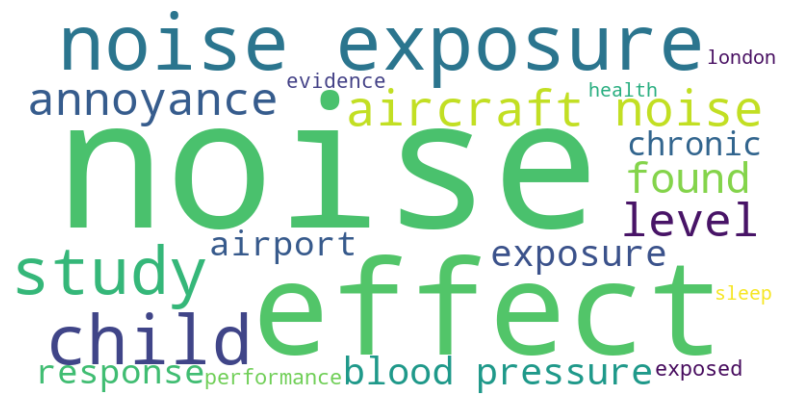

In [86]:
generate_word_cloud(preprocessed_text)